# Bandstructure Analysis of 1D Periodic Waveguides

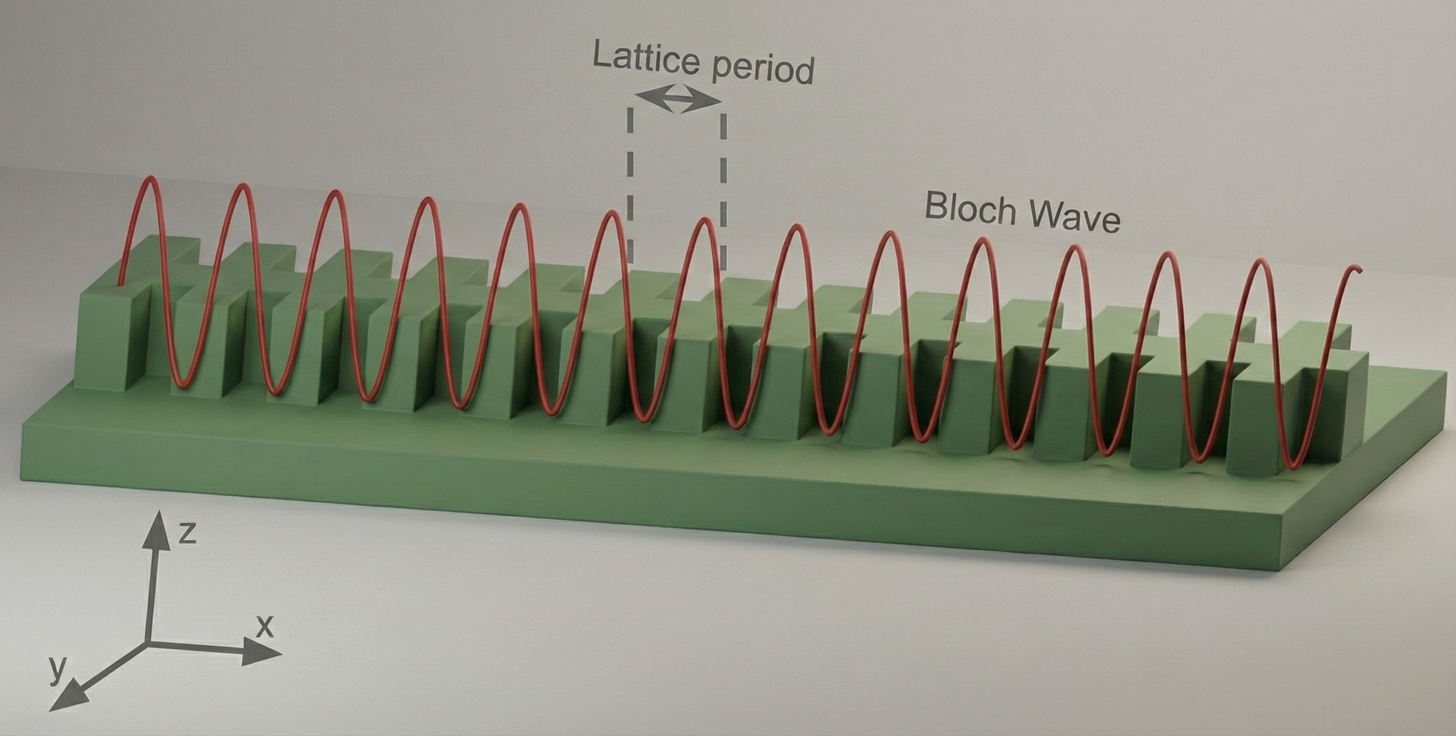


In this notebook, we study one-dimensional periodic waveguides and coupled-resonator optical waveguides (CROWs), which can be used as building blocks for **high-speed silicon photonic modulators and filters**. Periodic corrugations and resonant chains are commonly employed to engineer dispersion, create slow-light regions, and enhance light–matter interaction—key mechanisms for reducing device length and drive voltage in practical electro-optic modulators.

Accurately analyzing the bandstructure of these devices using brute-force full-wave methods such as FDTD can be computationally expensive, especially when sweeping geometric parameters or constructing large supercells. To address this, we use an **equivalent circuit model** combined with S-parameter retrieval to efficiently extract the complex bandstructure of periodic photonic structures. Despite its approximate effective-medium nature, this approach has been shown to agree remarkably well with rigorous electromagnetic simulations, while offering orders-of-magnitude improvements in speed and flexibility.

We first apply this framework to a one-dimensional periodic waveguide to compute dispersion relations and validate the results against full-wave simulations and published data. We then extend the same circuit-based methodology to analyze a **CROW**, where each resonator is modeled as a circuit element within a periodic chain. This allows us to efficiently extract the CROW bandstructure, group velocity, and slow-light behavior in a form that is directly relevant for modulator and integrated-photonics design.

**References**

1. Han, Changhao, et al. "Slow-light silicon modulator with 110-GHz bandwidth." Science Advances 9 (42), eadi5339 (2023). doi: [10.1126/sciadv.adi5339](https://doi.org/10.1126/sciadv.adi5339).
2. Pozar, David M. "Microwave engineering." Fourth Editions, University of Massachusetts at Amherst, John Wiley & Sons, Inc (2012).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer()
td.config.logging_level = "ERROR"

LiveViewer started at http://localhost:46361


## Geometric and Simulation Parameters

In this section, we define the geometric and simulation parameters for the one-dimensional periodic waveguide structure. The core geometry is based on the dimensions reported in [1] (the `tooth_length` is guessed because it is not mentioned in the paper text).

Then, we define the wavelength range of interest and convert it to the corresponding frequency range using $f = c_0 / \lambda$. This spectral window will be used to compute and visualize the bandstructure and the response of the periodic waveguide and CROW.


In [2]:
# Geometric parameters taken from the reference structure
wg_thickness = 0.220  # Silicon thickness
slab_thickness = 0.09  # Slab thickness
box_thickness = 2.0  # Buried oxide thickness
core_width = 0.455  # Central spine width
corrugation_depth = 0.190

# Derived tooth width from core width and corrugation depth
tooth_width = core_width + 2 * corrugation_depth

# Longitudinal periodicity and defect-related dimensions
a_lattice = 0.300
tooth_length = 0.1  # Not mentioned explicitly in the paper text
defect_length = 0.25

# Discretization of the structure in terms of supercells and grating periods
Nr = 10  # Number of CROW supercells
Np = 20  # Number of grating periods

# Wavelength range of interest for the bandstructure calculation
wavelengths = np.linspace(1.5, 1.6, 201)
freqs = td.C_0 / wavelengths

## Technology and Port Specification

Here we set up the technology stack and define the port specification needed for the Tidy3D simulation. We instantiate the SiEPIC platform with the specified slab and buried oxide thicknesses and assign it as the default technology. This defines the material and layer environment for all subsequent components.

Next, we define a rib-waveguide port specification. This rib port will be used when creating ports throughout the notebook.


In [3]:
# Define the SiEPIC technology using slab and oxide thicknesses
tech = siepic.ebeam(
    si_slab_thickness=slab_thickness,
    bottom_oxide_thickness=box_thickness,
)

# Assign this platform as the default technology
pf.config.default_technology = tech

# Port specification for rib waveguide
rib_spec = pf.PortSpec(
    description="Rib",
    width=2.5,
    limits=(-1, 1 + wg_thickness),
    target_neff=3.5,
    path_profiles=(
        (core_width, 0.0, tech.layers["Si"].layer),
        (3.0, 0.0, tech.layers["Si slab"].layer),
    ),
)

## Mode Profile and Effective Index Extraction

To verify the port specification and establish the baseline modal properties, we inspect the optical mode profile of the rib waveguide. We select the frequency at the center of our wavelength range and run a mode solver using the previously defined port specification. We then visualize the electric-field distribution of the fundamental mode and extract its effective index. This value will later serve as an input parameter to the circuit-based bandstructure model.


Uploading task 'Mode-ModeSolver…'Starting…
Starting task 'Mode-ModeSolver': https://tidy3d.simulation.cloud/workbench?taskId=mo-e030dd32-a448-4982-824e-17cb1b5e8186
Progress: 100% 


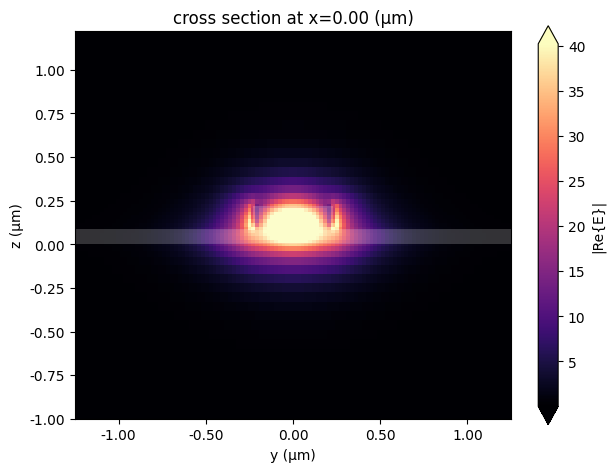

In [4]:
# Select the central frequency from the defined spectral range
freq0 = freqs[len(freqs) // 2]

# Run a mode solver for the rib port at the chosen frequency
mode_solver = pf.port_modes(rib_spec, [freq0])

# Plot the electric field profile of the fundamental mode
mode_solver.plot_field("E", mode_index=0, f=freq0)

# Extract the effective index of the fundamental mode
n_eff = mode_solver.data.n_eff.isel(mode_index=0).item()

## Unit Cell Construction

We now construct the unit cell of the one-dimensional periodic grating. After assembling the geometry, we automatically detect and assign ports based on the rib port specification. Finally, we attach a Tidy3D model with the specified port symmetry, enabling full-wave characterization of a single periodic cell for later circuit-based analysis.


In [5]:
# Create a component representing the grating unit cell
unit_cell = pf.Component("Grating Unit Cell")

# Define the corrugated tooth
tooth = pf.Rectangle(
    (-tooth_length / 2, -tooth_width / 2),
    (tooth_length / 2, tooth_width / 2),
)

# Define the central core region
core = pf.Rectangle(
    (-a_lattice / 2, -core_width / 2),
    (a_lattice / 2, core_width / 2),
)

# Define the slab region around the core
slab = pf.Rectangle(
    (-a_lattice / 2, -1.5),
    (a_lattice / 2, 1.5),
)

# Add geometric elements to appropriate layers
unit_cell.add((1, 0), tooth, core)
unit_cell.add((2, 0), slab)

# Automatically detect and assign ports based on the rib specification
unit_cell.add_port(unit_cell.detect_ports([rib_spec]))

# Attach a Tidy3D model with port symmetry
unit_cell.add_model(pf.Tidy3DModel(port_symmetries=[("P1", "P0")]))

# Visualize the constructed unit cell
viewer(unit_cell)

## Building the Full Grating

We now assemble the full periodic grating by repeating the unit cell structure. Using a parametric component allows us to flexibly sweep the number of periods or modify the lattice constant and unit cell later. 

Ports are automatically detected and added to the grating. We then attach two models to this component: a circuit model for the effective-medium bandstructure calculations, and an FDTD-based Tidy3D model for rigorous simulations. 


In [6]:
# Define a parametric component representing the full grating
@pf.parametric_component
def create_grating(Np=Np, a_lattice=a_lattice, unit_cell=unit_cell):
    """
    Creates a grating component by repeating a unit cell Np times.
    """
    # Create an empty component for the grating
    grating = pf.Component("Grating")

    # Place an array of unit cells with the specified lattice spacing
    uc_array = pf.Reference(
        component=unit_cell,
        columns=Np,
        rows=1,
        spacing=(a_lattice, 0.0),
    )
    grating.add(uc_array)

    # Detect and add ports using the rib specification
    grating.add_port(grating.detect_ports([rib_spec]))

    # Attach circuit and FDTD models
    grating.add_model(pf.CircuitModel(), "Circuit Model")
    grating.add_model(
        pf.Tidy3DModel(port_symmetries=[("P1", "P0")]),
        "FDTD Model",
    )

    return grating


# Instantiate the grating
grating = create_grating()
viewer(grating)

## Photonic Crystal Band Structure Calculation

This function extracts the complex band structure of a periodic device using the **Nicholson-Ross-Weir (NRW)** based S-parameter retrieval method. It treats the finite grating as a homogeneous effective medium with complex propagation constant $\gamma$.

**1. The Effective Medium Approach**
The ABCD transfer-matrix element $A$ is related to the scattering parameters by [2]:

$$
A = \frac{(1 + S_{11})(1 - S_{22}) + S_{12}\,S_{21}}{2 S_{21}}.
$$

Under the symmetry and reciprocity conditions typical for 1D periodic gratings:

- $S_{11} = S_{22}$
- $S_{12} = S_{21}$

this expression simplifies to the commonly used form:

$$A = \frac{1 - S_{11}^2 + S_{21}^2}{2 S_{21}}$$

From transmission line theory, this parameter corresponds to the propagation through a medium of length $L$:

$$A = \cosh(\gamma L)$$

where $\gamma = \alpha + i\beta$ is the complex propagation constant. By inverting this equation ($\gamma L = \text{arccosh}(A)$), we can separate the real and imaginary components:
* $\text{Re}(\gamma)$: Corresponds to the attenuation constant $\alpha$ (defining the **Bandgap Depth**).
* $\text{Im}(\gamma)$: Corresponds to the phase constant $\beta$ (defining the **Dispersion/Band Structure**).

**2. Phase Ambiguity and Auto-Calibration**
The mathematical operation $\text{arccosh}(A)$ is multi-valued; it only returns the principal value of the phase (typically within $[0, \pi]$). However, a physical device of length $L \gg a$ accumulates many cycles of phase ($\beta L \gg 2\pi$).

To resolve this **Branch Cut** problem, the function uses an **Auto-Calibration** routine:
1.  We calculate a "reference phase" using an approximate effective index ($n_{eff}$) provided by the user: $\phi_{ref} \approx k_0 \cdot n_{eff} \cdot L$.
2.  We find the integer number of $2\pi$ cycles ($m$) that minimizes the difference between the retrieved phase and the reference phase.
3.  This reconstructs the absolute physical wavevector $\beta$ in the extended zone.

**3. Brillouin Zone Folding**
Photonic crystals are traditionally analyzed in the **First Brillouin Zone** ($k_{norm} \in [0, 0.5]$). The retrieved wavevector is initially in the extended zone. We apply a "triangle wave" folding operation to map the data back into the first zone:

$$k_{reduced} = 0.5 - | (k_{norm} \pmod 1) - 0.5 |$$

**4. Group Index ($n_g$)**
The group index is calculated via numerical differentiation of the retrieved dispersion curve:

$$n_g = c \cdot \frac{d\beta}{d\omega}$$


### ⚠️ Limitations and Assumptions

**1. Approximation of Finite Structures**
This method assumes the Bloch mode has fully established itself. It extracts the *effective* parameters of the finite device simulated. 

**2. Single-Mode Assumption (Critical)**
**This mathematical retrieval is valid ONLY for single-mode waveguides.**
If the waveguide supports multiple modes (e.g., TE0 and TE1) or if there is significant coupling to radiation modes (leaky and high-loss modes), the S-parameters will represent a superposition of these modes. The analytic inversion will fail to distinguish them, resulting in a mathematically "averaged" or nonsensical dispersion curve.

**3. Effective Index Guess**
The accuracy of the unfolded phase calibration depends on `n_eff_approx`. It does not need to be perfect, but it must be close enough to identify the correct integer branch $m$. 


In [7]:
def calculate_bandstructure(freqs, s11, s21, L_device, a_lattice, n_eff_approx):
    """
    Calculates bandstructure with automatic phase calibration using effective index.

    Parameters:
    -----------
    freqs     : array-like
        List of frequency points (e.g., in Hz or THz).
    s11       : array-like (complex)
        Reflection coefficients (complex S11).
    s21       : array-like (complex)
        Transmission coefficients (complex S21).
    L_device  : float
        Total length of the simulated grating (e.g., Np * a).
    a_lattice : float
        The lattice constant (period) of the unit cell.
    n_eff_approx : float
        Approximate effective index for calibration

    Returns:
    --------
    k_real_norm : array
        The real part of the wavevector, normalized to the Brillouin Zone (k * a / pi).
        This is the standard 'Band Structure' plot.
    k_imag_norm : array
        The imaginary part (decay), normalized (delta * a).
        This shows the bandgap depth.
    ng: array
        Group index
    """
    # Calculate ABCD parameter
    A = (1 - s11**2 + s21**2) / (2 * s21)

    # Extract Raw Gamma (Complex Propagation Constant * L)
    gamma_L = np.arccosh(A)

    # Extract Raw Phase and Unwrap
    phase_raw = np.unwrap(np.imag(gamma_L))

    # --- AUTO-CALIBRATION ROUTINE ---
    # Calculate the "Expected" Phase based on n_eff
    beta_approx = (2 * np.pi * freqs / td.C_0) * n_eff_approx
    phase_expected = beta_approx * L_device

    # Fix Slope Direction (Sign Ambiguity)
    slope_raw = np.mean(np.gradient(phase_raw))
    slope_expected = np.mean(np.gradient(phase_expected))
    if np.sign(slope_raw) != np.sign(slope_expected):
        phase_raw = -phase_raw

    # Find the Integer 'm' (Cycle Ambiguity)
    diff = phase_expected - phase_raw
    m_cycles = np.round(np.mean(diff) / (2 * np.pi))

    print(
        f"Auto-calibration: Added {int(m_cycles)} * 2pi cycles to match n_eff={n_eff_approx}"
    )

    # Apply Correction
    phase_corrected = phase_raw + (m_cycles * 2 * np.pi)

    # -------------------------------

    # Calculate k-vector (Beta)
    k_vector = phase_corrected / L_device

    # Normalization for Plotting (ka / 2pi)
    k_real_norm = np.abs(k_vector) * a_lattice / (2 * np.pi)
    # Fold into First Brillouin Zone [0, 0.5]
    k_real_norm = 0.5 - np.abs(np.mod(k_real_norm, 1) - 0.5)

    # The dimensionless decay per unit cell
    k_imag_norm = np.real(gamma_L) * a_lattice / L_device

    # Calculate group index
    omega = 2 * np.pi * freqs
    dbeta_domega = np.abs(np.gradient(k_vector, omega))
    ng = td.C_0 * dbeta_domega

    return k_real_norm, k_imag_norm, ng

### Band Structure and Group Index Calculation

In this section, we simulate the S-parameters of a finite grating with multiple periods to minimize interface effects. By retrieving the complex propagation constant using the NRW inversion, we extract the photonic band structure, compare the results to both rigorous Tidy3D simulations ([standard rigorous bandstructure calculation](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/)) and published data, and also compute the group index. The results are in excellent agreement.

**Comparison with Reference Band Structure**

We observe a slight mismatch between the reference data (red markers) and both the circuit-model and Tidy3D curves. This discrepancy is expected and likely arises from several sources:  
- The **tooth length** is not reported in the paper and is approximated in our model, which changes the exact duty cycle and thus the band edges.  
- There may be small differences in the **material models** (e.g., dispersion and refractive indices of Si and SiO₂, or operating temperature) and other **simulation settings** (mesh resolution, PML design, number of periods, boundary conditions) between our setup and the original study.  

Given these uncertainties, the level of agreement in the band curvature and bandgap position supports that our circuit-based retrieval and full-wave simulations are capturing the essential physics of the published design.


Uploading task 'P0@0…'
Starting task 'P0@0': https://tidy3d.simulation.cloud/workbench?taskId=fdve-b43e519c-09bb-4a29-81ef-e3cb3fd32eb5
Progress: 100% 
Auto-calibration: Added 5 * 2pi cycles to match n_eff=2.5210319098413865


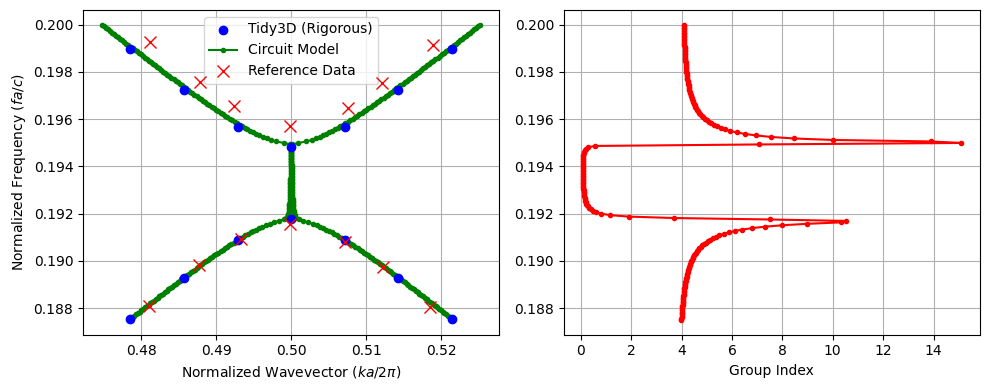

In [8]:
# This section evaluates bandstructure for a multi-period grating
Np_0 = 10
grating_0 = create_grating(Np=Np_0)

# Activate the rigorous FDTD model
grating_0.activate_model("FDTD Model")

# Compute S-parameters
s_matrix_grating_0 = grating_0.s_matrix(frequencies=freqs)

# Retrieve bandstructure using the circuit-model inversion
k_band, alpha_band, ng = calculate_bandstructure(
    freqs=freqs,
    s11=s_matrix_grating_0[("P0@0", "P0@0")],
    s21=s_matrix_grating_0[("P0@0", "P1@0")],
    L_device=Np_0 * a_lattice,
    a_lattice=a_lattice,
    n_eff_approx=n_eff,
)

# Data extracted from the paper (Fig. 1B)
paper_k = np.array(
    [
        0.48105,
        0.48778,
        0.49335,
        0.49979,
        0.50724,
        0.51220,
        0.51847,
        0.48113,
        0.48784,
        0.49237,
        0.49982,
        0.50757,
        0.51211,
        0.51885,
    ]
)
paper_freq = np.array(
    [
        0.18808,
        0.18981,
        0.19094,
        0.19158,
        0.19081,
        0.18974,
        0.18806,
        0.19929,
        0.19758,
        0.19655,
        0.19571,
        0.19649,
        0.19754,
        0.19916,
    ]
)

# Tidy3D "rigorous" bandstructure
tidy3d_freq = np.array(
    [
        [0.1875239435424648, 0.19897133233967337],
        [0.18928426483807095, 0.19724930008894026],
        [0.19088857219385474, 0.1956672320439793],
        [0.19175729862345767, 0.19480580946191053],
        [0.19088857207264562, 0.19566723206852332],
        [0.18928426515329203, 0.1972492999487063],
        [0.1875239437470226, 0.1989713323456029],
    ]
)
tidy3d_k = np.array([0.47857, 0.48571, 0.49285, 0.5, 0.50714, 0.51428, 0.52142])

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Dispersion Curve
ax1.scatter(
    np.repeat(tidy3d_k, tidy3d_freq.shape[1]),
    tidy3d_freq.flatten(),
    color="blue",
    label="Tidy3D (Rigorous)",
    zorder=7,
)
ax1.plot(k_band, freqs * a_lattice / td.C_0, ".-", color="green", label="Circuit Model")
ax1.plot(1 - k_band, freqs * a_lattice / td.C_0, ".-", color="green")
ax1.plot(
    paper_k,
    paper_freq,
    "x",
    color="red",
    markersize=8,
    label="Reference Data",
    zorder=10,
)
ax1.set_xlabel("Normalized Wavevector ($k a / 2\\pi$)")
ax1.set_ylabel("Normalized Frequency ($f a / c$)")
ax1.grid(True)
ax1.legend()

# Group Index Plot
ax2.plot(ng, freqs * a_lattice / td.C_0, "r.-")
ax1.set_ylabel("Normalized Frequency ($f a / c$)")
ax2.set_xlabel("Group Index")
ax2.grid(True)

plt.tight_layout()
plt.show()

## Modeling the CROW

### Defect Cell for CROW Resonator

To model a coupled-resonator optical waveguide (CROW), we first introduce a **defect unit cell** into the otherwise periodic grating. We create this defect by increasing the tooth length inside a single unit cell. This creates a resonant cavity embedded in the periodic structure.

We define an effective defect period $a_{\text{defect}}$ such that the overall cell length is adjusted consistently when the tooth length is increased. The core and slab rectangles are then extended to span this new period, while the transverse dimensions (core width and slab height) remain unchanged. We reuse the same rib-waveguide port specification and attach a Tidy3D model, enabling us to later compute the cavity mode and its coupling to neighboring cells when we assemble the full CROW.


In [9]:
# Create a component representing the defect unit cell
defect = pf.Component("Defect")

# Adjust the effective period to account for the longer tooth
a_defect = a_lattice + (defect_length - tooth_length)

# Define the enlarged tooth region for the defect
tooth = pf.Rectangle(
    (-defect_length / 2, -tooth_width / 2),
    (defect_length / 2, tooth_width / 2),
)

# Define the core region spanning the defect period
core = pf.Rectangle(
    (-a_defect / 2, -core_width / 2),
    (a_defect / 2, core_width / 2),
)

# Define the slab region for the defect period
slab = pf.Rectangle(
    (-a_defect / 2, -1.5),
    (a_defect / 2, 1.5),
)

# Add geometric elements to appropriate layers
defect.add((1, 0), tooth, core)
defect.add((2, 0), slab)

# Detect and add ports based on the rib specification
defect.add_port(defect.detect_ports([rib_spec]))

# Attach a Tidy3D model with port symmetry for the defect cell
defect.add_model(pf.Tidy3DModel(port_symmetries=[("P1", "P0")]))

# Return the defect component
viewer(defect)

### CROW Supercell

We now form a **supercell resonator** by placing the defect unit cell between two identical gratings that act as distributed Bragg reflectors. This configuration implements a single cavity of the CROW, where the gratings provide high reflectivity and the defect cell defines the resonant frequency.


In [10]:
# Create a component representing the CROW supercell (cavity + mirrors)
sc = pf.Component("Supercell")

# Add a reference to the left grating mirror
grating_left = sc.add_reference(grating)

# Add a reference to the right grating mirror
grating_right = sc.add_reference(grating)

# Add a reference to the central defect cavity
defect_ref = sc.add_reference(defect)

# Connect the left grating output to the defect input
defect_ref.connect("P0", grating_left["P1"])

# Connect the defect output to the right grating input
grating_right.connect("P0", defect_ref["P1"])

# Detect and add external ports at the ends of the supercell
sc.add_port(sc.detect_ports([rib_spec]))

# Attach a circuit model so the supercell can be used in a CROW network
sc.add_model(pf.CircuitModel())

# Return the constructed supercell
viewer(sc)

### CROW Construction and Transmission Simulation

We now construct the full CROW by periodically repeating the supercell that contains the defect cavity and its Bragg mirrors. The effective period of this CROW is the physical length of the supercell, given by

$sc\_length = 2 N_p a + a_{\text{defect}}$,

where the first term accounts for the two mirror sections and the second term is the defect cell.

We then:
- Instantiate a grating-like structure whose unit cell is the supercell, repeated $N_r$ times.
- Activate the **circuit model** of this composite structure.
- Compute the S-parameters over the frequency sweep and plot the transmission in dB.


Uploading task 'P0@0…'
Uploading task 'P0@0…'
Starting task 'P0@0': https://tidy3d.simulation.cloud/workbench?taskId=fdve-bd065bde-a8c4-47de-948e-f753046ee677
Starting task 'P0@0': https://tidy3d.simulation.cloud/workbench?taskId=fdve-f45a6c8b-f6b2-4859-be2f-55f83b4833ec
Progress: 100% 


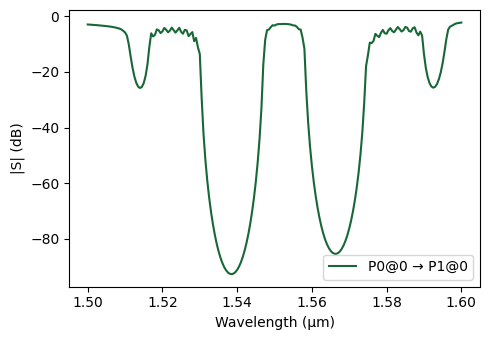

In [11]:
# Effective length of the supercell (two mirrors plus defect)
sc_length = 2 * Np * a_lattice + a_defect

# Create the CROW by repeating the supercell as the new unit cell
crow = create_grating(Np=Nr, a_lattice=sc_length, unit_cell=sc)

# Activate the circuit model for the CROW
crow.activate_model("Circuit Model")

# Compute S-parameters of the CROW over the frequency sweep
s_matrix_crow = crow.s_matrix(frequencies=freqs)

# Plot the S-matrix transmission in dB between input and output ports
_ = pf.plot_s_matrix(s_matrix_crow, y="dB", input_ports=["P0"], output_ports=["P1"])

### CROW Band Structure and Group Index

Now, we extract the **dispersion relation** and **group index** of a single CROW supercell and compare the results against the reference data from the paper.

We treat one supercell (defect cavity plus mirrors) as the periodic unit cell and apply the same S-parameter–based retrieval used for the photonic crystal waveguide:

- We build a CROW structure with **one supercell** and compute its S-parameters using the circuit model.
- Using the `calculate_bandstructure` function, we retrieve the normalized Bloch wavevector and the corresponding group index for this CROW unit cell.
- We then compare the resulting band diagram (wavelength vs. normalized wavevector) with the digitized data from the paper.


Auto-calibration: Added 21 * 2pi cycles to match n_eff=2.5210319098413865
Progress: 100% 


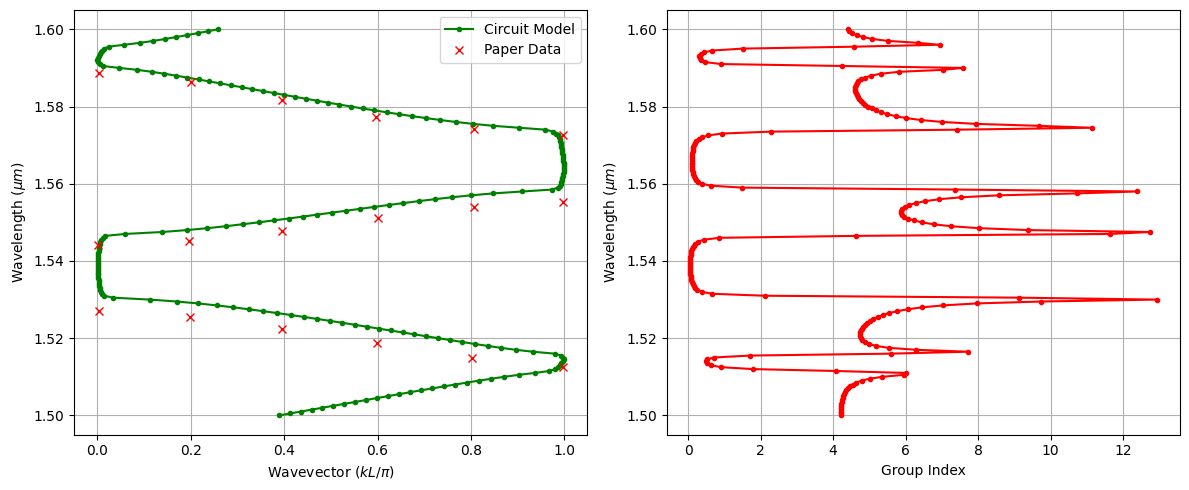

In [12]:
Np_0 = 1
crow_0 = create_grating(Np=Np_0, a_lattice=sc_length, unit_cell=sc)
crow_0.activate_model("Circuit Model")
s_matrix_crow_0 = crow_0.s_matrix(frequencies=freqs)

k_band, _, ng_crow = calculate_bandstructure(
    freqs=freqs,
    s11=s_matrix_crow_0[("P0@0", "P0@0")],
    s21=s_matrix_crow_0[("P0@0", "P1@0")],
    L_device=Np_0 * sc_length,
    a_lattice=sc_length,
    n_eff_approx=n_eff,
)

# Data from the paper (Fig. 1D)
paper_k = np.array(
    [
        0.99776,
        0.80313,
        0.59843,
        0.39597,
        0.19799,
        0.00224,
        0.00112,
        0.19575,
        0.39597,
        0.60179,
        0.80761,
        0.99776,
        0.99776,
        0.80761,
        0.59732,
        0.39597,
        0.20022,
        0.00336,
    ]
)

paper_wavelengths = np.array(
    [
        1.51258,
        1.51491,
        1.51877,
        1.52249,
        1.52558,
        1.52699,
        1.54402,
        1.54522,
        1.54764,
        1.55114,
        1.55402,
        1.55537,
        1.57270,
        1.57411,
        1.57736,
        1.58169,
        1.58632,
        1.58880,
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Band Structure (Dispersion Relation)
ax1.plot(k_band * 2, wavelengths, ".-", color="green", label="Circuit Model")
ax1.plot(paper_k, paper_wavelengths, "x", color="red", label="Paper Data")
ax1.legend()
ax1.set_xlabel("Wavevector ($k L / \\pi$)")
ax1.set_ylabel("Wavelength ($\\mu m$)")
ax1.grid(True)

# Plot Group Index
ax2.plot(ng_crow, wavelengths, "r.-")
ax2.set_ylabel("Wavelength ($\\mu m$)")
ax2.set_xlabel("Group Index")
ax2.grid(True)

plt.tight_layout()
plt.show()